# 6일차 과제 : SVM 서포트 벡터 머신

최적의 매개변수를 찾고 최종 서포트 벡터 머신 모델을 만들어라. 

그리고 sklearn의 roc_curve 함수를 이용하여 roc curve를 그리고 결과를 해석하라.

데이터 : 유방암 데이터(변수: 31개, 자료 수: 569개)

-.목표변수(diagnosis, 0: Malignant(악성,212개), 1: Benign(양성,357개)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
ds_bc = pd.read_csv('/home/pirl/Downloads/week4day1/유방암.csv',engine='python')
ds_bc.info()

#설명변수 X_i는 30개
#종속변수 Y는 이산형(1은 양성, 0은 악성)이지만 실제 분석에서는 연속형으로 처리
#결측치는 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

In [6]:
def remove_outlier_std(df):
    for i in range(0, len(df.iloc[1])):
        df = df[(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) < (3.6*df.iloc[:,i].std()))]
    return df
#3.6sigma를 벗어나는 data제거 함수

ds_bc_z=remove_outlier_std(ds_bc)
ds_bc_z.info()
#494개로 이상치 제거
#DT에 비해 이상치에 민감함
#data의 분포가 전반적으로 UCL을 초과하는 경향이 강하고
#모델의 일반성, 범용성을 위해 이상치 제거 실시

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 1 to 568
Data columns (total 31 columns):
diagnosis                  494 non-null int64
mean radius                494 non-null float64
mean texture               494 non-null float64
mean perimeter             494 non-null float64
mean area                  494 non-null float64
mean smoothness            494 non-null float64
mean compactness           494 non-null float64
mean concavity             494 non-null float64
mean concave points        494 non-null float64
mean symmetry              494 non-null float64
mean fractal dimension     494 non-null float64
radius error               494 non-null float64
texture error              494 non-null float64
perimeter error            494 non-null float64
area error                 494 non-null float64
smoothness error           494 non-null float64
compactness error          494 non-null float64
concavity error            494 non-null float64
concave points error       494 no

#  데이터 분할 7 : 3

In [7]:
ds_bc_y = ds_bc_z['diagnosis']
ds_bc_x = ds_bc_z.drop('diagnosis',axis=1, inplace=False)

ds_bc_train_x, ds_bc_test_x, ds_bc_train_y, ds_bc_test_y = train_test_split(ds_bc_x, ds_bc_y, test_size=0.3, random_state=1234)

print("train data X size: {}".format(ds_bc_train_x.shape))
print("train data Y size: {}".format(ds_bc_train_y.shape))
print("test data X size: {}".format(ds_bc_test_x.shape))
print("test data Y size: {}".format(ds_bc_test_y.shape))

train data X size: (345, 30)
train data Y size: (345,)
test data X size: (149, 30)
test data Y size: (149,)


#  SVC의 dafault parameter

In [8]:
svm_un=SVC(random_state=1234)
svm_un.fit(ds_bc_train_x,ds_bc_train_y)

print("Accuracy on training set:{:.3f}".format(svm_un.score(ds_bc_train_x,ds_bc_train_y)))
print("Accuracy on training set:{:.3f}".format(svm_un.score(ds_bc_test_x,ds_bc_test_y)))
print()
print(svm_un)

Accuracy on training set:1.000
Accuracy on training set:0.664

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)


#  Scale 없이 바로 SVM모델링을 하니 0.664의 낮은 정확도

In [9]:
#C를 0.1부터 1까지 0.1단위 조정
train_ac=[]
test_ac=[]
para_C=[]

for C in range(10):
    svm1 = SVC(C=(C+1)/10,random_state=1234)
    svm1.fit(ds_bc_train_x, ds_bc_train_y)
    para_C.append((C+1)/10)
    train_ac.append(svm1.score(ds_bc_train_x,ds_bc_train_y))
    test_ac.append(svm1.score(ds_bc_test_x,ds_bc_test_y))
    
ds_acc1 =  pd.DataFrame()
ds_acc1['C'] = para_C
ds_acc1["TrainAccuraccy"] =train_ac
ds_acc1["TestAccuracy"] = test_ac

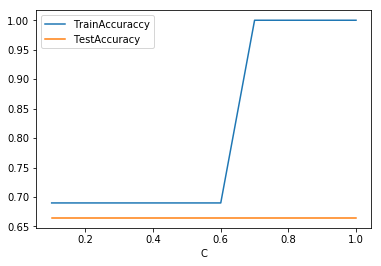

In [10]:
ds_acc1.round(3)
ds_acc1.set_index("C",inplace=False).plot.line()

In [11]:
#Gamma를 0.1부터 1까지 0.1단위 조정
train_ac=[]
test_ac=[]
para_g=[]

for gamma in range(1,10):
    svm2 = SVC(gamma=gamma/10,random_state=1234)
    svm2.fit(ds_bc_train_x, ds_bc_train_y)
    para_g.append(gamma/10)
    train_ac.append(svm2.score(ds_bc_train_x,ds_bc_train_y))
    test_ac.append(svm2.score(ds_bc_test_x,ds_bc_test_y))
    
ds_acc2 =  pd.DataFrame()
ds_acc2['Gamma'] = para_g
ds_acc2["TrainAccuraccy"] =train_ac
ds_acc2["TestAccuracy"] = test_ac

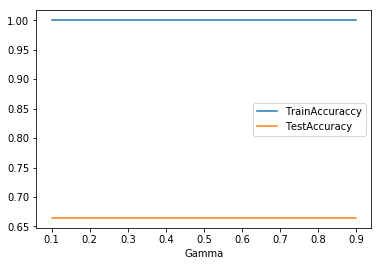

In [12]:
ds_acc2.round(3)
ds_acc2.set_index("Gamma",inplace=False).plot.line()

# 스케일링을 하지 않으니 C,gamma에 의핸 test 정확도가 변화도 없고 낮음

In [13]:
ds_bc_train_x_scaled = scale(ds_bc_train_x,axis=0)

ds_bc_test_x_scaled = scale(ds_bc_test_x,axis=0)

pd.DataFrame(ds_bc_train_x_scaled, columns =ds_bc_train_x.columns).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.282168,0.648202,-0.303015,-0.332160,-0.645192,-0.691557,-0.663907,-0.405154,-0.357236,0.144621,...,-0.445902,-0.250709,-0.463854,-0.479913,-1.799479,-1.091804,-1.072346,-0.959126,-1.357312,-0.880508
1,-0.046204,-1.154314,-0.041189,-0.190461,0.846238,0.549125,-0.211344,0.353602,-0.003940,0.779640,...,-0.174371,-1.133953,-0.247286,-0.292761,0.335599,0.184242,-0.273961,0.510331,0.754202,0.830826
2,1.699930,-0.286163,1.756025,1.739044,1.059191,1.880306,2.150308,1.877432,0.528084,-0.284739,...,1.834456,-0.622422,1.795791,1.810210,1.680012,2.249091,3.027319,2.297255,1.906670,0.732537
3,1.069569,0.008125,1.044648,1.048036,-0.556968,-0.044517,0.234787,0.767412,0.469894,-1.213816,...,1.138029,0.226719,1.065334,1.098243,-0.722068,-0.118591,0.008302,0.748474,-0.085971,-0.631650
4,-0.332732,1.276017,-0.336114,-0.372229,-1.288613,-0.458913,-0.270242,-0.666707,-1.105395,-0.338860,...,-0.332764,1.080976,-0.404022,-0.376713,-0.444725,0.945312,0.964995,0.244777,-0.053734,1.011370


# 스케일링 실행

In [14]:
svm_un_scaled = SVC(random_state=1234)
svm_un_scaled.fit(ds_bc_train_x_scaled,ds_bc_train_y)
print("Accuracy on training set:{:.3f}".format(svm_un_scaled.score(ds_bc_train_x_scaled,ds_bc_train_y)))
print("Accuracy on test set: {:.3f}".format(svm_un_scaled.score(ds_bc_test_x_scaled,ds_bc_test_y)))

Accuracy on training set:0.994
Accuracy on test set: 0.960


# 스케일링 이후 test 정확도가 매우 상승
# 기존 data간 scale이 잘 맞지 않았던 것으로 추정

In [17]:
#c를 0.1부터 5까지 0.1단위 조정
train_ac=[]
test_ac=[]
para_C=[]

for C in range(50):
    svm1_scaled = SVC(C=C+1,random_state=1234)
    svm1_scaled.fit(ds_bc_train_x_scaled, ds_bc_train_y)
    para_C.append(C+1)
    train_ac.append(svm1_scaled.score(ds_bc_train_x_scaled,ds_bc_train_y))
    test_ac.append(svm1_scaled.score(ds_bc_test_x_scaled,ds_bc_test_y))
    
ds_acc3_scaled =  pd.DataFrame()
ds_acc3_scaled['C'] = para_C
ds_acc3_scaled["TrainAccuraccy"] =train_ac
ds_acc3_scaled["TestAccuracy"] = test_ac

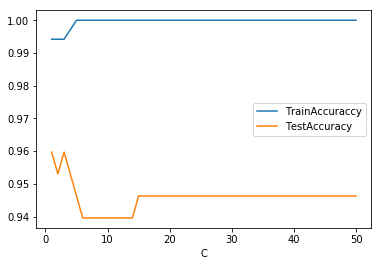

In [18]:
ds_acc3_scaled.round(3)
ds_acc3_scaled.set_index("C",inplace=False).plot.line()

# C가 커질수록 test 정확도가 감소하는 경향을 보이다가
# 특정 구간 이후 유지

In [19]:
#Gamma를 0.1부터 1까지 0.1단위 조정
train_ac=[]
test_ac=[]
para_g=[]

for gamma in range(1,10):
    svm2_scaled = SVC(gamma=gamma/10,random_state=1234)
    svm2_scaled.fit(ds_bc_train_x_scaled, ds_bc_train_y)
    para_g.append(gamma/10)
    train_ac.append(svm2_scaled.score(ds_bc_train_x_scaled,ds_bc_train_y))
    test_ac.append(svm2_scaled.score(ds_bc_test_x_scaled,ds_bc_test_y))
    
ds_acc2_scaled =  pd.DataFrame()
ds_acc2_scaled['Gamma'] = para_g
ds_acc2_scaled["TrainAccuraccy"] =train_ac
ds_acc2_scaled["TestAccuracy"] = test_ac

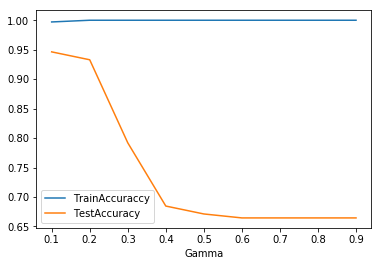

In [20]:
ds_acc2_scaled.round(3)
ds_acc2_scaled.set_index("Gamma",inplace=False).plot.line()

# gamma 가 커질수록 test 정확도가 감소하는 경향을 보이다가
# 특정 구간 이후에는 거의 변화 없음

# C와 gamma를 적당히 조절하면서 test 정확도를 개선

In [110]:
svm_un=SVC(random_state=1234, C=1.5, gamma=0.1,probability=True)
svm_un.fit(ds_bc_train_x_scaled,ds_bc_train_y)

print("Accuracy on training set:{:.3f}".format(svm_un.score(ds_bc_train_x_scaled,ds_bc_train_y)))
print("Accuracy on test set:{:.3f}".format(svm_un.score(ds_bc_test_x_scaled,ds_bc_test_y)))
print()
print(svm_un)

Accuracy on training set:1.000
Accuracy on test set:0.946

SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=1234, shrinking=True,
  tol=0.001, verbose=False)


# C는 특정 구간을 제외하고는 대부분 test 정확도를 유지
# C보다는 gamma에 매우 민감함

# -----------------------------------------------------------------------------
#  GridSearch
# -----------------------------------------------------------------------------

#  파라미터에 적당하게 범위를 지정하며 반복적으로 최적 파라미터를 찾음

In [144]:
svc=SVC(random_state=1234) # c:8 g:1e-2 // 0.962 : 0.932

param_grid = {'kernel':['rbf','linear'],
              'gamma': [1, 2],
              'C': [7, 8, 9]}
scores = ['accuracy', 'recall']
for sc in scores:
    clf=GridSearchCV(svc,param_grid,cv=10,scoring=sc,n_jobs=-1)
    print("# Tuning hyper-parameters for %s" % sc)
    clf.fit(ds_bc_train_x,ds_bc_train_y)
    print(clf.best_params_)
    print("best_score : ", np.round(clf.best_score_,3))

# Tuning hyper-parameters for accuracy
{'C': 8, 'gamma': 1, 'kernel': 'linear'}
best_score :  0.962
# Tuning hyper-parameters for recall
{'C': 8, 'gamma': 1, 'kernel': 'linear'}
best_score :  0.934


# GridSearch에 의하면 C=8, gamma=1, kernel=linear 를 선택
# 해당 값뿐 아니라 근처의 값들도 최고치를 보임

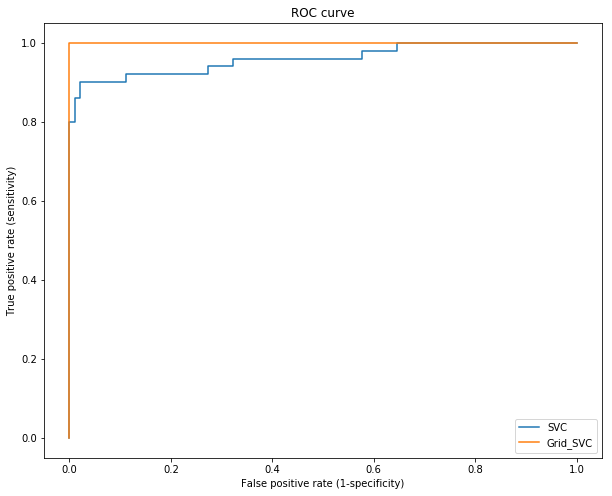

In [164]:
svc=SVC(C=1.5,gamma=0.1,kernel='rbf',probability=True)
Grid_svc=SVC(C=8,gamma=1,kernel='linear',probability=True)

Grid_svc.fit(ds_bc_test_x_scaled,ds_bc_test_y)
y_pred_svc_p =svm_un.predict_proba(ds_bc_test_x_scaled)[:,1]
y_pred_svc_grid =Grid_svc.predict_proba(ds_bc_test_x_scaled)[:,1]

models=[y_pred_svc_p,y_pred_svc_grid]
label=['SVC','Grid_SVC']

plt.figure(figsize=(10, 8))
m=np.arange(2)
for m in m:
    fpr, tpr,thresholds= metrics.roc_curve(ds_bc_test_y,models[m])
    plt.plot(fpr,tpr,label=label[m])

plt.title('ROC curve')
plt.xlabel('False positive rate (1-specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.legend(loc=4,)

# gridsearch로 찾은 파라미터들의 AUC=1로 보임
# 과적합이므로 일반성을 위한다면 manual로 찾은 모델이 적당해 보임
# test data에 대한 정확도가 목표면 grid의 파라미터가 좋으나
# 일반적으로는 (C=1.5,gamma=0.1,kernel='rbf')파라미터의 
# manual 모델이 더 우수하다고 봄

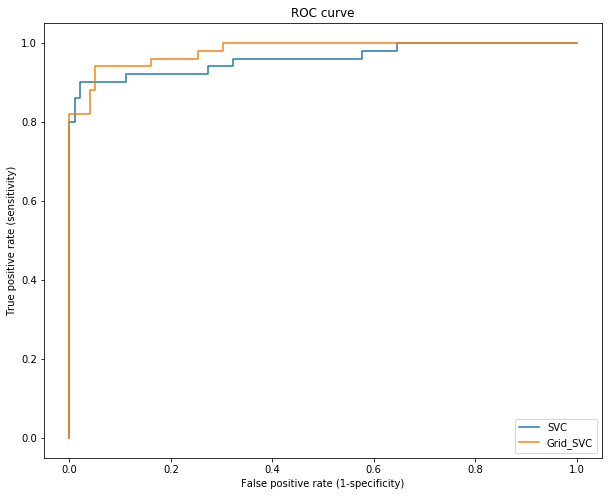

In [170]:
svc2=SVC(C=1.5,gamma=0.1,kernel='rbf',probability=True)
Grid_svc2=SVC(C=0.00001,gamma=1,kernel='linear',probability=True)

Grid_svc2.fit(ds_bc_test_x_scaled,ds_bc_test_y)
y_pred_svc_p2 =svm_un.predict_proba(ds_bc_test_x_scaled)[:,1]
y_pred_svc_grid2 =Grid_svc2.predict_proba(ds_bc_test_x_scaled)[:,1]

models=[y_pred_svc_p2,y_pred_svc_grid2]
label=['SVC','Grid_SVC']

plt.figure(figsize=(10, 8))
m=np.arange(2)
for m in m:
    fpr, tpr,thresholds= metrics.roc_curve(ds_bc_test_y,models[m])
    plt.plot(fpr,tpr,label=label[m])

plt.title('ROC curve')
plt.xlabel('False positive rate (1-specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.legend(loc=4,)

# grid parameter에서 c를 낮추면 과적합이 어느 정도 해결
# 경우에 따라서 필요한 모형을 사용하기 좋음